## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load data
df = pd.read_csv('PFE-Pfizer.csv')

## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,41.375713,41.546490,41.072105,41.138519,33.265743,26667781
2019-03-04,41.214420,41.356735,40.683113,40.863377,33.043259,22805820
2019-03-05,40.882355,41.034157,40.654648,40.692600,32.905163,26529812
2019-03-06,40.626186,40.673622,39.487667,39.715370,32.114948,22410359
2019-03-07,39.715370,39.743832,39.136623,39.269451,31.754372,29046132
...,...,...,...,...,...,...
2024-05-24,28.670000,28.990000,28.549999,28.879999,28.879999,22576300
2024-05-28,28.799999,28.879999,28.129999,28.299999,28.299999,32371200
2024-05-29,28.160000,28.170000,27.690001,27.820000,27.820000,24241700


## Scale Data

In [4]:
# Select 'Close' column
data = df['Close'].values

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train and test

In [6]:
# Define the size of train and test
train_size = int(len(data_scaled) * 0.7)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[0 : train_size, :]
test_data = data_scaled[train_size : len(data_scaled), :]

## Create and add data into X, y

In [7]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [8]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get last data for test
train_last_windowsize = train_data[-sequence_length:]

test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

# Reshape inputs to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Build Model

In [9]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam', loss='mean_squared_error')

D:\Anaconda\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
28/28 - 8s - 269ms/step - loss: 0.0362
Epoch 2/50
28/28 - 3s - 95ms/step - loss: 0.0091
Epoch 3/50
28/28 - 3s - 117ms/step - loss: 0.0073
Epoch 4/50
28/28 - 3s - 121ms/step - loss: 0.0074
Epoch 5/50
28/28 - 3s - 108ms/step - loss: 0.0068
Epoch 6/50
28/28 - 3s - 100ms/step - loss: 0.0073
Epoch 7/50
28/28 - 3s - 97ms/step - loss: 0.0081
Epoch 8/50
28/28 - 3s - 92ms/step - loss: 0.0066
Epoch 9/50
28/28 - 3s - 106ms/step - loss: 0.0060
Epoch 10/50
28/28 - 3s - 104ms/step - loss: 0.0064
Epoch 11/50
28/28 - 5s - 182ms/step - loss: 0.0080
Epoch 12/50
28/28 - 3s - 106ms/step - loss: 0.0047
Epoch 13/50
28/28 - 3s - 111ms/step - loss: 0.0051
Epoch 14/50
28/28 - 3s - 117ms/step - loss: 0.0046
Epoch 15/50
28/28 - 2s - 84ms/step - loss: 0.0045
Epoch 16/50
28/28 - 3s - 101ms/step - loss: 0.0043
Epoch 17/50
28/28 - 3s - 111ms/step - loss: 0.0042
Epoch 18/50
28/28 - 3s - 104ms/step - loss: 0.0040
Epoch 19/50
28/28 - 3s - 101ms/step - loss: 0.0042
Epoch 20/50
28/28 - 2s - 87ms/step - loss: 0

## Predict and Inverse Transform the Predictions

In [11]:
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step


## Calculate the error of the model

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, mean_absolute_error
# Evaluate the accuracy of test

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_msle = mean_squared_log_error(y_test, y_pred)


print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)
print(f"MAE on Test dataset: ", test_mae)

MAPE on Test dataset:  0.021639730306948025
RMSE on Test dataset:  0.945209403582673
MSLE on Test dataset:  0.0006810010235412592
MAE on Test dataset:  0.7518069396308498


## Predict Close price for 90 next days

In [13]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 90 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Predict Close price for 90 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_90_days = []

for i in range(90):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_90_days.append(next_day_pred[0][0])
    
    # Update information of the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/

In [14]:
# Show the result of predict 90 next days 
y_next_90_days = scaler.inverse_transform(np.array(y_next_90_days).reshape(-1, 1))
print(y_next_90_days.flatten())

[28.704126 28.580141 28.514338 28.501104 28.523705 28.565283 28.61422
 28.664722 28.71519  28.766115 28.818523 28.873182 28.930363 28.989908
 29.05145  29.114563 29.178848 29.243969 29.309645 29.375648 29.441769
 29.507805 29.573587 29.638948 29.703756 29.767874 29.831205 29.89365
 29.955145 30.015635 30.075077 30.133434 30.190708 30.2469   30.302025
 30.356112 30.409163 30.461216 30.51231  30.56246  30.611732 30.660183
 30.707846 30.754786 30.801023 30.846624 30.891628 30.936064 30.97999
 31.02343  31.066425 31.109015 31.151226 31.193079 31.234583 31.275793
 31.316708 31.357355 31.397747 31.437874 31.477753 31.517395 31.55681
 31.596    31.634968 31.67371  31.712229 31.750525 31.788595 31.826437
 31.864054 31.90144  31.938591 31.975506 32.012184 32.048622 32.084816
 32.12076  32.156464 32.191917 32.227123 32.262077 32.29678  32.331226
 32.365425 32.399372 32.433067 32.46651  32.499702 32.53265 ]


## Model visualization

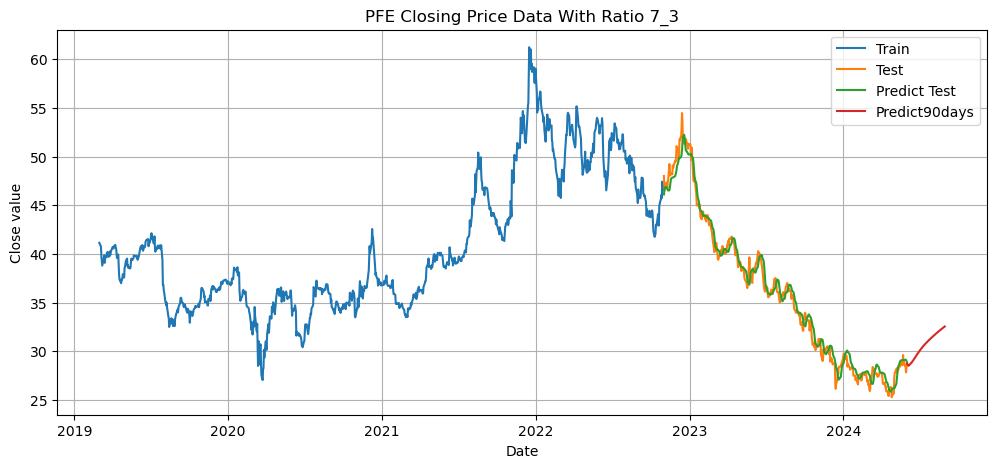

In [15]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Test set
plt.plot(df[train_size:].index, test_data)

# Predict in test set
plt.plot(df[train_size:].index, y_pred)

# Predict 90 next days
plt.plot(index_next_90_days, y_next_90_days)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict90days'])
plt.grid()
plt.title("PFE Closing Price Data With Ratio 7_3")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('Image/RNN_73_90days_PFE.png')
plt.show()